In [1]:
# Third Party Imports
import pandas as pd
import matplotlib.pyplot as plt
#import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
import pickle
from exphelperfunctions import abbrv_num
from exphelperfunctions import objectToFile
from exphelperfunctions import objectFromFile
from exphelperfunctions import add_value_labels

INFO: Pandarallel will run on 12 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [2]:
#Open UNSW-NB15 small train/test split
df_train = pd.read_csv('/mnt/h/UNSW-NB15/train_test_set/UNSW_NB15_training-set.csv', sep=',',header=0,skipinitialspace=True)
df_test = pd.read_csv('/mnt/h/UNSW-NB15/train_test_set/UNSW_NB15_testing-set.csv', sep=',',header=0,skipinitialspace=True)

In [4]:
print(df_train['label'].unique())
print(df_train['attack_cat'].unique())
print(df_train.columns)

[0 1]
['Normal' 'Reconnaissance' 'Backdoor' 'DoS' 'Exploits' 'Analysis'
 'Fuzzers' 'Worms' 'Shellcode' 'Generic']
Index(['id', 'dur', 'proto', 'service', 'state', 'spkts', 'dpkts', 'sbytes',
       'dbytes', 'rate', 'sttl', 'dttl', 'sload', 'dload', 'sloss', 'dloss',
       'sinpkt', 'dinpkt', 'sjit', 'djit', 'swin', 'stcpb', 'dtcpb', 'dwin',
       'tcprtt', 'synack', 'ackdat', 'smean', 'dmean', 'trans_depth',
       'response_body_len', 'ct_srv_src', 'ct_state_ttl', 'ct_dst_ltm',
       'ct_src_dport_ltm', 'ct_dst_sport_ltm', 'ct_dst_src_ltm',
       'is_ftp_login', 'ct_ftp_cmd', 'ct_flw_http_mthd', 'ct_src_ltm',
       'ct_srv_dst', 'is_sm_ips_ports', 'attack_cat', 'label'],
      dtype='object')


# Data composition
Training: Total amount of instances = 175,341

Testing: Total amount of instances = 82,332


# One hot encoding

In [5]:
# One hot encoding for protocol
ohe_df = pd.get_dummies(df_train['proto'])
df_train = df_train.join(ohe_df)
ohe_list = list(ohe_df.columns)
    
ohe_df = pd.get_dummies(df_test['proto'])
df_test = df_test.join(ohe_df)

In [6]:
print(df_train.columns)
print(df_test.columns)
print(set(ohe_list).symmetric_difference(set(ohe_df.columns))) #test set contains two extra protocols, unnecessary to use.

Index(['id', 'dur', 'proto', 'service', 'state', 'spkts', 'dpkts', 'sbytes',
       'dbytes', 'rate',
       ...
       'visa', 'vmtp', 'vrrp', 'wb-expak', 'wb-mon', 'wsn', 'xnet', 'xns-idp',
       'xtp', 'zero'],
      dtype='object', length=176)
Index(['id', 'dur', 'proto', 'service', 'state', 'spkts', 'dpkts', 'sbytes',
       'dbytes', 'rate',
       ...
       'visa', 'vmtp', 'vrrp', 'wb-expak', 'wb-mon', 'wsn', 'xnet', 'xns-idp',
       'xtp', 'zero'],
      dtype='object', length=178)
{'icmp', 'rtp'}


In [7]:
#Get input columns and corresponding label vector
#Use duration, src bytes&packets per flow, dst bytes&packets per flow, mean src/dst bytes per flow AND src TTL + 
#features = df_train.drop(['id','proto','service','state','attack_cat','label'],axis=1)

label = 'label'
features = ['dur','sbytes','dbytes','spkts','dpkts','smean','dmean','sinpkt','dinpkt','sttl','ct_state_ttl']
features.extend(ohe_list)
X_train = df_train[features]
y_train = df_train[label]
X_test = df_test[features]
y_test = df_test[label]

#Split in train and test set
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, shuffle=False)

In [8]:
print(y_train.describe())
print(y_test.describe())

count    82332.000000
mean         0.550600
std          0.497436
min          0.000000
25%          0.000000
50%          1.000000
75%          1.000000
max          1.000000
Name: label, dtype: float64
count    175341.000000
mean          0.680622
std           0.466237
min           0.000000
25%           0.000000
50%           1.000000
75%           1.000000
max           1.000000
Name: label, dtype: float64


# Random Forest implementation

In [9]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
cfs = []
preds = []
for i in range(5):
    rf_clf = RandomForestClassifier(n_estimators=100,min_samples_split=10,min_samples_leaf=5,max_samples=0.8,criterion='gini',n_jobs=5)
    rf_clf.fit(X_train,y_train)
    y_pred = rf_clf.predict(X_test)
    cfs.append(confusion_matrix(y_test, y_pred))
    preds.append([y_test, y_pred])

In [13]:
print(cfs)
print(np.shape(cfs))
cf = np.mean(cfs,axis=(0))
print(cf)
print(np.std(cfs,axis=(0)))
objectToFile(preds, "nb15_preds_"+label)

[array([[ 53909,   2091],
       [ 14520, 104821]]), array([[ 53988,   2012],
       [ 14636, 104705]]), array([[ 53963,   2037],
       [ 14605, 104736]]), array([[ 53878,   2122],
       [ 14122, 105219]]), array([[ 53965,   2035],
       [ 14401, 104940]])]
(5, 2, 2)
[[ 53940.6   2059.4]
 [ 14456.8 104884.2]]
[[ 40.64775517  40.64775517]
 [186.15842715 186.15842715]]


In [3]:
#Grab results from file
from sklearn.metrics import confusion_matrix
preds_mem = objectFromFile("nb15_preds_label")
cfs = []
for pred_tuple in preds_mem:
    cfs.append(confusion_matrix(pred_tuple[0], pred_tuple[1]))

In [4]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
paper1_acc = 0.9919
paper2_acc = 0.8913
acc_scores = [[accuracy_score(pred_tuple[0], pred_tuple[1]) for pred_tuple in preds_mem]]
rec_scores = [[recall_score(pred_tuple[0], pred_tuple[1]) for pred_tuple in preds_mem]]
tn, fp, fn, tp = np.mean(cfs,axis=0).ravel()
print(tn,fp,fn,tp)
spec_score = tn / (tn+fp)
print(np.mean(acc_scores), "\n")
print(np.mean(rec_scores), "\n")
print(spec_score)

#print('std. dev %\n', np.divide(np.std(cfs,axis=0),np.mean(cfs,axis=0))*100)

53940.6 2059.4 14456.8 104884.2
0.9058052594658408 

0.8788614139315072 

0.963225


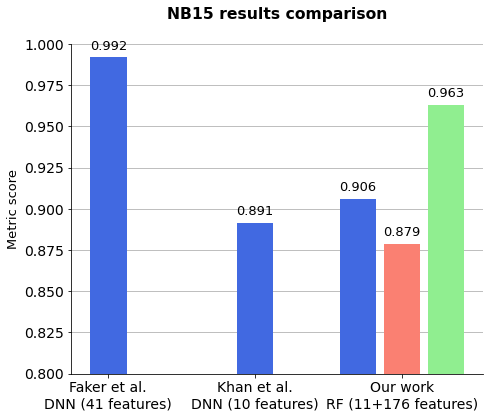

In [6]:
import matplotlib.patches as mpatches
#Colors
clr_acc = 'royalblue'
clr_rec = 'salmon'
clr_spec = 'lightgreen'

acc_patch = mpatches.Patch(color=clr_acc, label='accuracy')
rec_patch = mpatches.Patch(color=clr_rec, label='recall')
spec_patch = mpatches.Patch(color=clr_spec, label='specificity')

labels = ['Faker et al.\nDNN (41 features)', 'Khan et al.\nDNN (10 features)', 'Our work\nRF (11+176 features)']
x = np.arange(len(labels))*10
width = 2.5  # the width of the bars
pad_width = 3
scores = [paper1_acc,paper2_acc,np.mean(acc_scores),np.mean(rec_scores),spec_score]

fig, ax = plt.subplots(figsize=(7,6))

#Spawn bar(s) of group 1
plt.bar(x[0], height=scores[0], width=width, color=clr_acc)

#Spawn bar(s) of group 2
plt.bar(x[1], height=scores[1], width=width, color=clr_acc)

#Spawn bar(s) of group 3
plt.bar(x[2]-pad_width, height=scores[2], width=width, color=clr_acc)
plt.bar(x[2], height=scores[3], width=width, color=clr_rec)
plt.bar(x[2]+pad_width, height=scores[4], width=width, color=clr_spec)

#Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

#Set plot details
plt.rc('font', size=13)
plt.ylabel('Metric score')
plt.yticks(size='14')
plt.xticks(size='14')
plt.ylim([0.8, 1])
plt.title("NB15 results comparison", fontweight='bold',  pad=25)
ax.set_xticks(x)
ax.set_xticklabels(labels)
add_value_labels(ax)
#ax.legend(handles=[acc_patch,rec_patch,spec_patch],bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
ax.set_axisbelow(True)
plt.grid(axis='y')
fig.tight_layout()
plt.savefig('nb15_binaryclass_bars.png',bbox_inches='tight')
plt.show()

In [45]:
#Plot confusion matrix
import seaborn as sns
#labels = ['Benign','Malicious']

#Standard heatmap
cf_norm = cf/cf.sum(axis=1)[:,None]
cf_percentages = ["{0:.2%}".format(value) for value in cf_norm.flatten()]
cf_numbers = [abbrv_num(value) for value in cf.flatten()]
cf_labels = ['{v1}\n({v2})'.format(v1=v1, v2=v2) for v1,v2 in zip(cf_percentages,cf_numbers)]
cf_labels = np.asarray(cf_labels).reshape(cf.shape)

fig, ax = plt.subplots(figsize=(6, 6))
plt.rc('font', size=14)
column_labels = sorted(y_test.unique())
#column_labels[6] = 'Benign'
column_labels = ['Benign', 'Malicious']
sns.heatmap(cf_norm, annot=cf_labels, fmt='',cmap='Blues',cbar=False, vmin=0.0, vmax=1.0, ax=ax, xticklabels=column_labels, yticklabels=column_labels)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.yticks(size='12')
plt.xticks(rotation='65', size='12')
plt.title("NB15 mean binary classification matrix")
plt.savefig('nb15_binaryclass_cf.png',bbox_inches='tight')
plt.show()

NameError: name 'cf' is not defined

In [70]:
importance = rf_clf.feature_importances_
# summarize feature importance
for i,v in sorted(enumerate(importance),key=lambda x: x[1], reverse=True):
    print('Feature: %s, Score: %.5f' % (features[i],v))

Feature: sbytes, Score: 0.18759
Feature: smean, Score: 0.15470
Feature: udp, Score: 0.09853
Feature: ct_state_ttl, Score: 0.06670
Feature: sttl, Score: 0.06041
Feature: dbytes, Score: 0.06001
Feature: dmean, Score: 0.05686
Feature: dur, Score: 0.05539
Feature: dinpkt, Score: 0.05345
Feature: sinpkt, Score: 0.05153
Feature: dpkts, Score: 0.04995
Feature: spkts, Score: 0.04294
Feature: tcp, Score: 0.03142
Feature: unas, Score: 0.01203
Feature: ospf, Score: 0.00270
Feature: arp, Score: 0.00231
Feature: sctp, Score: 0.00226
Feature: any, Score: 0.00036
Feature: ipv6, Score: 0.00036
Feature: sep, Score: 0.00036
Feature: gre, Score: 0.00032
Feature: sun-nd, Score: 0.00028
Feature: igmp, Score: 0.00023
Feature: rsvp, Score: 0.00023
Feature: mobile, Score: 0.00023
Feature: swipe, Score: 0.00021
Feature: pim, Score: 0.00016
Feature: tcf, Score: 0.00016
Feature: larp, Score: 0.00015
Feature: rvd, Score: 0.00013
Feature: aris, Score: 0.00012
Feature: sccopmce, Score: 0.00012
Feature: ipx-n-ip, Sc

# Rerun experiment with less features to confirm feature importances

In [7]:
#Get input columns and corresponding label vector
#Use duration, src bytes&packets per flow, dst bytes&packets per flow, mean src/dst bytes per flow AND src TTL + 
#features = df_train.drop(['id','proto','service','state','attack_cat','label'],axis=1)

label = 'label'
features = ['sbytes','udp','smean']
#features.extend(ohe_list)
X_train = df_train[features]
y_train = df_train[label]
X_test = df_test[features]
y_test = df_test[label]



In [8]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
cfs = []
preds = []
for i in range(5):
    rf_clf = RandomForestClassifier(n_estimators=100,min_samples_split=10,min_samples_leaf=5,max_samples=0.8,criterion='gini',n_jobs=5)
    rf_clf.fit(X_train,y_train)
    y_pred = rf_clf.predict(X_test)
    cfs.append(confusion_matrix(y_test, y_pred))
    preds.append([y_test, y_pred])

In [9]:
print(cfs)
print(np.shape(cfs))
cf = np.mean(cfs,axis=(0))
print(cf)
print(np.std(cfs,axis=(0)))
#objectToFile(preds, "nb15_preds_"+label)

[array([[ 53293,   2707],
       [ 15482, 103859]]), array([[ 53300,   2700],
       [ 15302, 104039]]), array([[ 53385,   2615],
       [ 15421, 103920]]), array([[ 53316,   2684],
       [ 15340, 104001]]), array([[ 53256,   2744],
       [ 15267, 104074]])]
(5, 2, 2)
[[ 53310.    2690. ]
 [ 15362.4 103978.6]]
[[42.34619227 42.34619227]
 [78.72636153 78.72636153]]


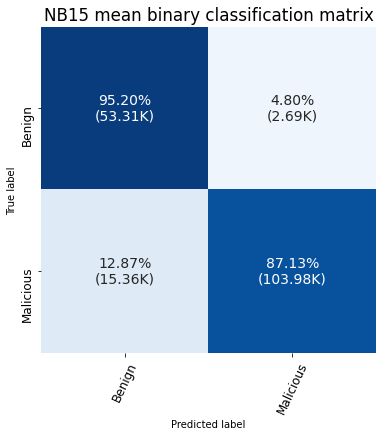

In [10]:
#Plot confusion matrix
import seaborn as sns
#labels = ['Benign','Malicious']

#Standard heatmap
cf_norm = cf/cf.sum(axis=1)[:,None]
cf_percentages = ["{0:.2%}".format(value) for value in cf_norm.flatten()]
cf_numbers = [abbrv_num(value) for value in cf.flatten()]
cf_labels = ['{v1}\n({v2})'.format(v1=v1, v2=v2) for v1,v2 in zip(cf_percentages,cf_numbers)]
cf_labels = np.asarray(cf_labels).reshape(cf.shape)

fig, ax = plt.subplots(figsize=(6, 6))
plt.rc('font', size=14)
column_labels = sorted(y_test.unique())
#column_labels[6] = 'Benign'
column_labels = ['Benign', 'Malicious']
sns.heatmap(cf_norm, annot=cf_labels, fmt='',cmap='Blues',cbar=False, vmin=0.0, vmax=1.0, ax=ax, xticklabels=column_labels, yticklabels=column_labels)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.yticks(size='12')
plt.xticks(rotation='65', size='12')
plt.title("NB15 mean binary classification matrix")
#plt.savefig('nb15_binaryclass_cf.png',bbox_inches='tight')
plt.show()

In [11]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score

acc_scores = [[accuracy_score(pred_tuple[0], pred_tuple[1]) for pred_tuple in preds]]
rec_scores = [[recall_score(pred_tuple[0], pred_tuple[1]) for pred_tuple in preds]]
tn, fp, fn, tp = np.mean(cfs,axis=0).ravel()
print(tn,fp,fn,tp)
spec_score = tn / (tn+fp)
print(np.mean(acc_scores), "\n")
print(np.mean(rec_scores), "\n")
print(spec_score)

#print('std. dev %\n', np.divide(np.std(cfs,axis=0),np.mean(cfs,axis=0))*100)

53310.0 2690.0 15362.4 103978.6
0.8970440456025687 

0.8712730746348699 

0.9519642857142857
